# Logistic Regression and Employee Attrition (Phase 3 Project Submission)

* Student name: Konnor Clark
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Morgan
* Blog post URL: https://datadruid.blogspot.com/

## Project Goal:

This project aims to determine key features of employment to mitigate employee attrition

## Overview and Business Understanding/Questions

My stakeholder is IBM, and the company wishes to mitigate employee attrition.  

They would like advice on what aspects of employment potentially contribute to employee attrition.

What features increase an employee's likelihood to leave IBM the most?

What features reduce an employee's likelihood to leave IBM the most?

## Data Source and Exploration

This data comes from the IBM HR Analytics Employee Attrition & Performance dataset at kaggle.com.

All features in the dataset were used. The most relevant were:
* Total Working Years
* Years in Current Role
* Job Level
* Number of Companies Worked
* Distance from Home

## Importing and Previewing Data

I first importeed and previewed the data. 

In [31]:
#importing necessary libraries, etc
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#importing datafile
df = pd.read_csv('employee_attrition.csv')
#previewing data
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


#### Comments:
It looks like we have numerical and categorical data with pretty self-explanatory columns. 

In [2]:
#verifying all features have all rows and no null values. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

#### Comment on Findings:
Nothing that needs cleaning, and we have no null values. Our target variable, Attrition, currently contains the strings "Yes" or "No" so we'll have to change that for our analysis. 

In [3]:
#checking percentage of employees in data with attrition
df.Attrition.value_counts(normalize=True)
# 

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

#### Comment on Findings:
Random chance would be right as a baseline 83.88% of the time. The following models will aim for higher than that. An unbalanced dataset with many more "No" than "Yes" for the Attrition column. 

## Manipulating the Data, Logistic Regression Models

In [4]:
#Changing target feature Attrition to numerical values instead of categorical
df.Attrition = df.Attrition.map({'Yes': 1, 'No': 0})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

#### Comments:
.map() worked, and our Attrition column now contains integers in place of the strings, "Yes" and "No."

In [6]:
#previewing the change to numerical values for Attrition feature
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Dividing the Training and Testing Data

In [7]:
y = df.Attrition
X = df.drop('Attrition', axis = 1)
#normalizing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Visualizing Most Correlated Features
I'm curious which features may closely correlate with Attrition of the get-go. These will be something IBM would wish to keep an eye on, and are important for my recommendations.  

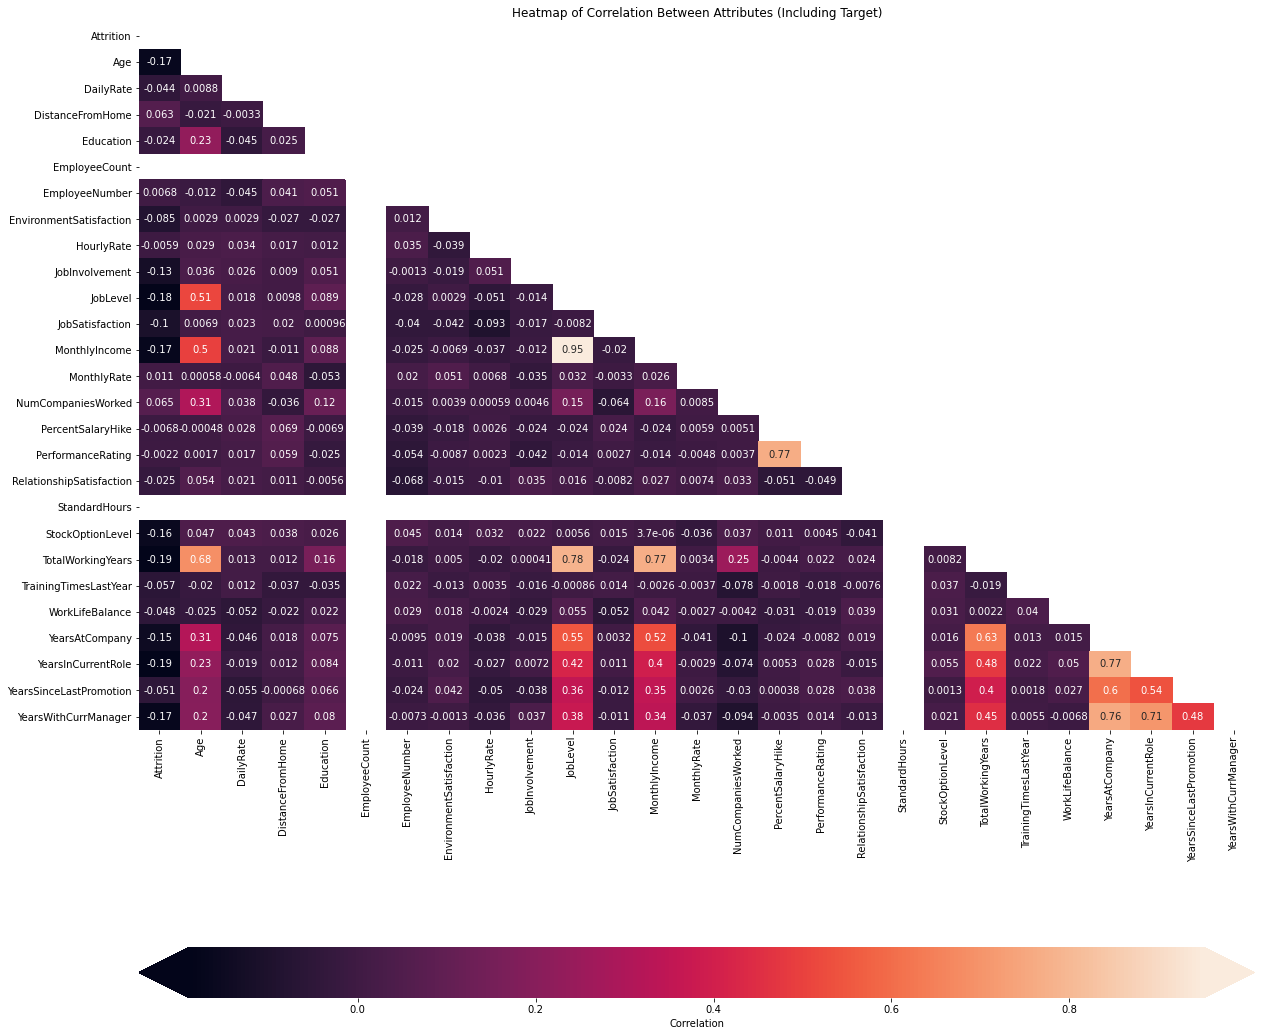

In [8]:
# Creates a df with the target as the first column,
# then computes the correlation matrix
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(20, 20))

# Plots a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");
#heat map below

#### Comment on Findings:
It looks like none of our features are very highly correlated. The features below are the least correlated, and therefore correspond to the least attrition are:

* Total Working Years
* Years in Current Role
* Job Level
As these features increase, the employee's risk of attrition descreases


Conversely, the features that were the most highly correlated, and therefore correspond to the most attrition are:
* Number of Companies Worked
* Distance from Home
* Monthly Rate
As these features increase, the employee's risk of attrition increases.

I'm surprised by the Monthly Rate, though again it is a very low correlation. 

I'm also curious as to the distribution of the least correlated features (the ones that correlate with the lowest attrition), so I take a look at those below.


In [9]:
#Describing top 3 most correlating features
df[['YearsInCurrentRole', 'TotalWorkingYears', 'JobLevel']].describe()

,YearsInCurrentRole,TotalWorkingYears,JobLevel
count,1470.000000,1470.000000,1470.000000
mean,4.229252,11.279592,2.063946
std,3.623137,7.780782,1.106940
min,0.000000,0.000000,1.000000
25%,2.000000,6.000000,1.000000
50%,3.000000,10.000000,2.000000
75%,7.000000,15.000000,3.000000
max,18.000000,40.000000,5.000000


#### Comments:
The range is interesting, and the majority of the data falls in between 2 and 7 years for the Years In Current Role, 6-15 for total working years, and 1-3 for Job level.  It would be interesting to investigate how high the attrition is for the lowest quartile, and how low the attrition is for the highest quartile.  

## Visualizing Most and Least Correlated Features

#### Comments:
I thought it important to visualize these significant features for myself and for my stakeholders. A Heat Map is useful, but it doesn't necsesarily convey the type of relationship between the two variables that would be understandable to a general audience. 

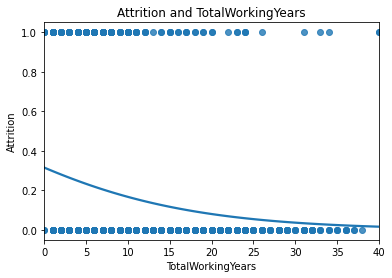

In [10]:
least_correlated_feature1 = 'TotalWorkingYears'
least_correlated_feature2 = 'YearsInCurrentRole'
least_correlated_feature3 = 'JobLevel'
most_correlated_feature1 = 'NumCompaniesWorked'
most_correlated_feature2 = 'DistanceFromHome'
most_correlated_feature3 = 'MonthlyRate'

sns.regplot(x=X_train[least_correlated_feature1], y=y_train, data=df, logistic=True, ci=None).set(title=
    'Attrition and {}'.format(least_correlated_feature1));

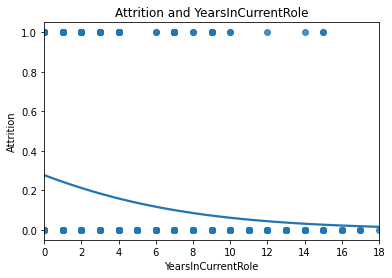

In [11]:
sns.regplot(x=X_train[least_correlated_feature2], y=y_train, data=df, logistic=True, ci=None).set(title=
    'Attrition and {}'.format(least_correlated_feature2));

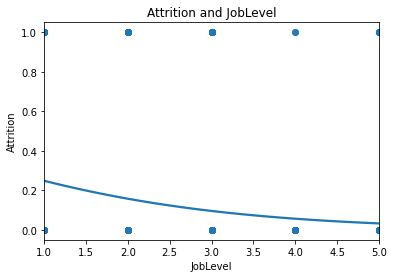

In [12]:
sns.regplot(x=X_train[least_correlated_feature3], y=y_train, data=df, logistic=True, ci=None).set(title=
    'Attrition and {}'.format(least_correlated_feature3));

#### Comments on Findings:
We can see that as these features increase, attrition decreases. Attrition lowers with higher number of working years, the years in current role, and the job level

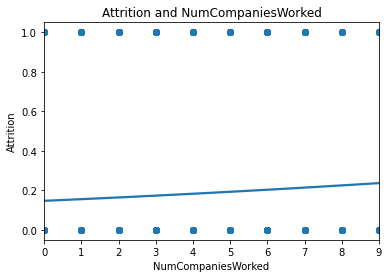

In [13]:
sns.regplot(x=X_train[most_correlated_feature1], y=y_train, data=df, logistic=True, ci=None).set(title=
    'Attrition and {}'.format(most_correlated_feature1));

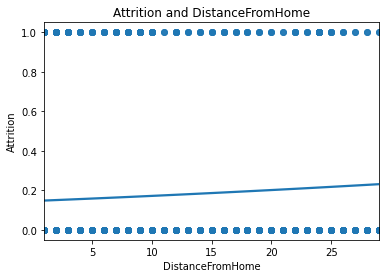

In [14]:
sns.regplot(x=X_train[most_correlated_feature2], y=y_train, data=df, logistic=True, ci=None).set(title=
    'Attrition and {}'.format(most_correlated_feature2));

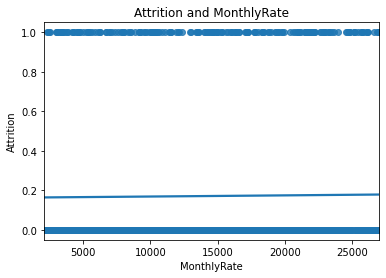

In [15]:
sns.regplot(x=X_train[most_correlated_feature3], y=y_train, data=df, logistic=True, ci=None).set(title=
    'Attrition and {}'.format(most_correlated_feature3));

#### Comments on Findings:
We can see that as these features increase, attrition increases. Attrition rises slightly with higher number of companies worked, the distance from home, and the monthly rate. 

#### Commented Out:
The below cell is an attempt at a model with only the highest correlating features, but this model was poorer than keeping all features.

In [16]:
#Removing high attrition features and keeping the low attrition features
#running this cell and the following cells resulted in a less accurate model than keeping all features
# y2 = df.Attrition
# X2 = df[['Age', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'StockOptionLevel', 'TotalWorkingYears',
#        'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']]
# #normalizing data
# X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=42)

In [17]:
#Verifying we have the current distribution of attrition/no attrition in training and test data
print("Train percent attrition/no attrition:", y_train.value_counts(normalize=True)[1])
print("Test percent attrition/no attrition: ", y_test.value_counts(normalize=True)[1])


Train percent attrition/no attrition: 0.17150635208711434
Test percent attrition/no attrition:  0.13043478260869565


#### Comment on Findings
A reasonably close distribution of y values between train and test data. 

### Dummy Variables for Categorical Features
Below I create dummy variables for the dataset's categorical features, and concatenate them together again.

In [18]:
#Separating X data into continuous vs. categorical
X_train_cont = X_train.select_dtypes(include='number')
X_test_cont = X_test.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(exclude='number')
X_test_cat = X_test.select_dtypes(exclude='number')

#Dummy encoding categorical values using OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train_cat)
X_test_cat = ohe.transform(X_test_cat)

X_train_preprocessed = np.concatenate([X_train_cont, X_train_cat.todense()], axis=1)
X_test_preprocessed = np.concatenate([X_test_cont, X_test_cat.todense()], axis=1)

In [19]:
X_train = X_train_preprocessed
X_test = X_test_preprocessed

#### Commented Out:
The below two cells is an attempt at a model with removal of the features with the highest P values, but this model was poorer than keeping all features. Here, I realized, that it makes sense why removing the highest or lowest correlating features might negatively impact the accuracy of the model. If the model doesn't have the lowest correlating features to work with, how could it determine the highest ones?  

In [20]:
# Building a logistic regression model using statsmodels
#log_reg = sm.Logit(y_train, X_train).fit()
#print(log_reg.summary())

In [21]:
#Dropping features with high P Values
#This resulted in a model that was less accurate than including all features.

# df2 = df.drop(columns=['DailyRate', 'Education', 'EmployeeCount', "EmployeeNumber",
#                        'HourlyRate', 'JobLevel','MonthlyIncome', 'MonthlyRate', 
#                        'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
#                        'StockOptionLevel', 'BusinessTravel', 'EducationField', 
#                        'MaritalStatus', 'OverTime'])

#dummy_dataframe = pd.get_dummies(df2)
# y3 = dummy_dataframe.Attrition
# X3 = dummy_dataframe.drop('Attrition', axis = 1)
# X_train, X_test, y_train, y_test = train_test_split(X3, y3, random_state=42)

## Initial Model

#### Comments:
The initial model. I used the F1 Score and a confusion matrix to see the baseline for this first model, particularly because the accuracy score wouldn't be as helpful with such an unbalanced dataset. 

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

baseline_model = LogisticRegression(solver='newton-cg', class_weight='balanced')
baseline_model.fit(X_train, y_train)

# Predicting on the test data
pred_test = baseline_model.predict(X_test)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Creating a function for the confusion matrix
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
            # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

conf_matrix(y_test, pred_test)

The f1 score for the testing data: 0.3684210526315789


{'TP': 28, 'TN': 244, 'FP': 76, 'FN': 20}

## XGBoost

#### Comments:
I thought I would use XGBoost to improve upon this first model to see what comes out of it. 

In [35]:
# Train XGBoost model
clf = XGBClassifier()

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Fit XGBClassifier
clf.fit(X_train, y_train, sample_weight=classes_weights, eval_metric='rmse')

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
training_precision = precision_score(y_train, training_preds)
test_precision = precision_score(y_test, test_preds)
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)
training_f1 = f1_score(y_train, training_preds)
test_f1 = f1_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation Accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))
print('Training F1 Score: {:.4}%'.format(training_f1 * 100))
print('Validation F1 Score: {:.4}%'.format(test_f1 * 100))

conf_matrix(y_test, test_preds)

Training Accuracy: 100.0%
Validation Accuracy: 86.96%
Training Precision: 100.0%
Validation Precision: 50.0%
Training Recall: 100.0%
Validation Recall: 33.33%
Training F1 Score: 100.0%
Validation F1 Score: 40.0%


{'TP': 16, 'TN': 304, 'FP': 16, 'FN': 32}

#### Comment on findings
XGBoost has improved upon the intial model: The F1 score and the confusion matrix have both improved. Let's see if we can tweak it a bit more with GridSearchCV

## GridSearchCV
I know that combining XGBoost and GridSearchCV can sometimes result in superior models, so I wanted to use GridSearch on the above model to see if any further improvements could be made. 

In [37]:
#Cycled through various parameters to save on processing time, below were best options

param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [8, 9, 10],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.3, 0.5],
    'n_estimators': [26, 27],
}

In [38]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', refit='recall', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train, eval_metric='rmse')

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
training_precision = precision_score(y_train, training_preds)
test_precision = precision_score(y_test, test_preds)
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)
training_f1 = f1_score(y_train, training_preds)
test_f1 = f1_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation Accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))
print('Training F1 Score: {:.4}%'.format(training_f1 * 100))
print('Validation F1 Score: {:.4}%'.format(test_f1 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 8
min_child_weight: 2
n_estimators: 26
subsample: 0.5

Training Accuracy: 95.01%
Validation Accuracy: 86.96%
Training Precision: 97.86%
Validation Precision: 50.0%
Training Recall: 72.49%
Validation Recall: 16.67%
Training F1 Score: 83.28%
Validation F1 Score: 25.0%


#### Comment on Findings:
This has led to a less accurate model than through XGBoost, so we will return to that model as our final one.

## Confusion Matrix
To visualize the accuracy of this model, I have created a confusion matrix

In [39]:
#Creating Confusion Matrix
# logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = clf.fit(X_train, y_train, eval_metric='rmse')
y_hat_test = test_preds

conf_matrix(y_test, y_hat_test)

{'TP': 8, 'TN': 312, 'FP': 8, 'FN': 40}

In [40]:
#Checking work with sklearn
from sklearn.metrics import confusion_matrix

# Print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[312   8]
 [ 40   8]]


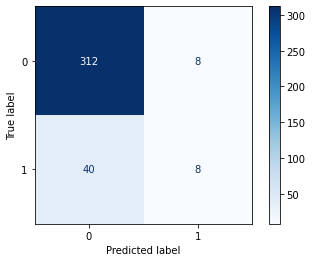

In [41]:
#Visual of Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=model_log.classes_)
disp.plot(cmap=plt.cm.Blues);

## Conclusion and Recommendation

IBM should consider the following when mitigating risks of employee attrition:

Employee attrition slightly increases as the number of companies worked and the distance from home increase. 

IBM should be cautious when hiring employees who have worked for a large number of companies, and incentivize those employees to stay if they wish to mitigate attrition.  Employees who live far from home could also be incentivised to move closer to their place of work, perhaps through relocation packages.  

Employee attrition decreases as total working years, number of years in current role, and job level increase. 

The longer an employee has been with IBM, and the higher job level they have obtained, the more likely that employee is to stay with the company. IBM should incentivize longevity with the company, perhaps through stock or other perk options, and should maintain pathways of upward mobility for employees. 

More information is needed to act on this information. IBM should conduct further surveys to investigate why more senior employees have stayed, and why more junior employees may leave. Consider more qualitative data to help unpack quantitative survey questions, and consider further inquiries regarding diversity and belonging to determine whether there is a pattern in the type of employee attrition that is taking place. 
